In [15]:
import numpy as np
import glob
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import pyproj as proj
from scipy.stats import norm

def folder2cube(files, size_raster):
    base_set = glob.glob(files)
    cube = np.zeros(size_raster + (len(base_set),))
    for i, model in enumerate(base_set): 
        cube[:,:,i] = np.loadtxt(model, skiprows = 1).reshape(size_raster)
    return cube, len(base_set)

def my_fault(file):
    fault = np.loadtxt(file, skiprows = 1).reshape(size_raster)
    fault[fault < -9900.] = 'nan'
    return fault

def show_it(data, turn = True):
    if turn:
        plt.imshow(data.T, origin="upper")
    else:
        plt.imshow(data, origin="upper")
    plt.colorbar()
    plt.show()
    
size_raster = (250,162)

In [16]:
base_cube, base_n = folder2cube('data/Hackaton/BaseSet/MapSimu__*.data',size_raster)
top_cube, top_n = folder2cube('data/Hackaton/TopSet/MapSimu__*.data',size_raster)

In [17]:
volume_file = 'data/Hackaton/VolumeDistribution/Volumes'

vol = pd.read_csv(volume_file, delim_whitespace=True)

In [63]:
ds = xr.Dataset()  

X_corner = 390885
Y_corner = 7156947
dx, dy = 25, 25

#top_model = np.min([np.min(base_cube),np.min(top_cube)])
#bottom_model = np.max([np.max(base_cube),np.max(top_cube)])

top_model = 950
bottom_model = 1050
dz = 100

xx = np.linspace(X_corner, X_corner+size_raster[0]*dx, size_raster[0])
yy = np.linspace(Y_corner, Y_corner+size_raster[1]*dy, size_raster[1])
zz = np.linspace(top_model, bottom_model, dz)
rr = np.array(range(0,np.shape(base_cube)[2]))

model = np.linspace(0, top_model, base_n)

ds.coords['X'] = xx
ds.coords['Y'] = yy
ds.coords['Z'] = zz
ds.coords['MODEL'] = model

ds['BASE'] = (('X', 'Y', 'MODEL'), base_cube)
ds['TOP'] = (('X', 'Y', 'MODEL'), top_cube)

In [64]:
base_mean = ds['BASE'].mean(dim='MODEL')
base_std = ds['BASE'].std(dim='MODEL')

top_mean = ds['TOP'].mean(dim='MODEL')
top_std = ds['TOP'].std(dim='MODEL')

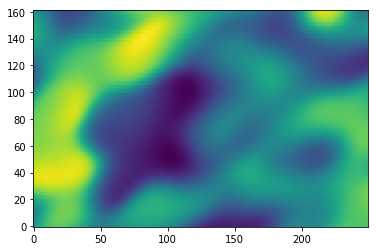

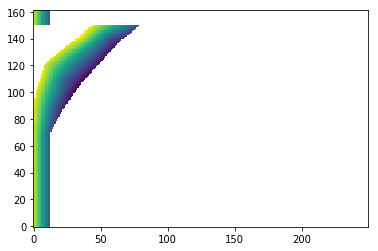

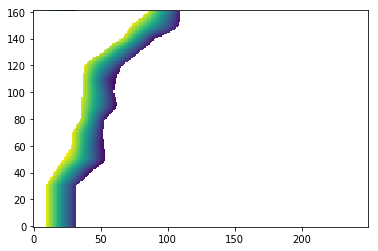

In [77]:
fault_max = my_fault('data/Hackaton/Fault_Max/Isochron.data')
fault_min = my_fault('data/Hackaton/Fault_Min/Isochron.data')

last_line_min = fault_min[:,30]
last_line_max = fault_max[:,70]

for y in range(0,len(yy)): 
    if np.isnan(fault_min[:,y]).all():
        fault_min[:,y] = last_line_min
    if np.isnan(fault_max[:,y]).all():
        fault_max[:,y] = last_line_max

plt.imshow(ds['BASE'][dict(MODEL=130)].T, origin='lower')
plt.show()

plt.imshow(fault_max.T, origin='lower')
plt.show()

plt.imshow(fault_min.T, origin='lower')
plt.show()

In [78]:
fault_frame = np.zeros(size_raster)
fault_dist = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)): 
    for y in range(0,len(yy)): 
        if (np.isfinite(fault_max[x,y]) or np.isfinite(fault_min[x,y])):
            fault_frame[:x,y] = 1

for x in range(0,len(xx)): 
    for y in range(0,len(yy)):
        if fault_frame[x,y] == 1:
            for z in range(1,len(zz)-1):
                if (zz[z+1] >= fault_min[x,y] >= zz[z-1]):
                    
                    print(zz[z-1] , fault_min[x,y], fault_max[x,y])
                    
                    
                    #fault_dist[x,y,z] = (fault_min[x,y] + fault_max[x,y])
                
#plt.imshow(fault_dist[:,:,5].T, origin='lower')
#plt.show()


1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034.8484848484848 1036.1099853515625 nan
1035.858585858586 1036.1099853515625 nan
1034

968.1818181818181 969.9656982421875 nan
969.1919191919192 969.9656982421875 nan
985.3535353535353 986.734130859375 nan
986.3636363636364 986.734130859375 nan
998.4848484848485 1000.1404418945312 nan
999.4949494949495 1000.1404418945312 nan
1008.5858585858585 1010.180419921875 nan
1009.5959595959596 1010.180419921875 nan
1015.6565656565657 1017.2726440429688 nan
1016.6666666666666 1017.2726440429688 nan
1021.7171717171717 1023.2543334960938 nan
1022.7272727272727 1023.2543334960938 nan
1026.7676767676767 1028.023193359375 nan
1027.7777777777778 1028.023193359375 nan
1030.8080808080808 1032.7921142578125 nan
1031.8181818181818 1032.7921142578125 nan
1035.858585858586 1037.5577392578125 nan
1036.8686868686868 1037.5577392578125 nan
1039.8989898989898 1041.8465576171875 nan
1040.909090909091 1041.8465576171875 nan
1043.939393939394 1045.953369140625 nan
1044.949494949495 1045.953369140625 nan
1047.979797979798 1049.5740966796875 nan
950.0 950.5467529296875 nan
966.1616161616162 967.6837158

950.0 950.8502197265625 nan
957.070707070707 958.8847045898438 nan
958.0808080808081 958.8847045898438 nan
965.1515151515151 966.4464721679688 nan
966.1616161616162 966.4464721679688 nan
972.2222222222222 973.6519165039062 nan
973.2323232323232 973.6519165039062 nan
979.2929292929293 980.71337890625 nan
980.3030303030303 980.71337890625 nan
986.3636363636364 987.7697143554688 nan
987.3737373737374 987.7697143554688 nan
993.4343434343434 994.63037109375 nan
994.4444444444445 994.63037109375 nan
999.4949494949495 1001.006591796875 nan
1000.5050505050505 1001.006591796875 nan
1004.5454545454545 1006.433349609375 nan
1005.5555555555555 1006.433349609375 nan
1009.5959595959596 1011.4210815429688 nan
1010.6060606060606 1011.4210815429688 nan
1013.6363636363636 1015.16455078125 nan
1014.6464646464647 1015.16455078125 nan
1015.6565656565657 1017.16015625 nan
1016.6666666666666 1017.16015625 nan
1017.6767676767677 1019.0560913085938 nan
1018.6868686868687 1019.0560913085938 nan
1019.69696969696

953.030303030303 953.6321411132812 nan
976.2626262626262 977.5401611328125 nan
977.2727272727273 977.5401611328125 nan
1000.5050505050505 1002.2335815429688 nan
1001.5151515151515 1002.2335815429688 nan
1028.7878787878788 1029.8101806640625 nan
1029.79797979798 1029.8101806640625 nan
958.0808080808081 960.003662109375 nan
959.0909090909091 960.003662109375 nan
984.3434343434343 985.8831176757812 nan
985.3535353535353 985.8831176757812 nan
1012.6262626262626 1014.2177124023438 nan
1013.6363636363636 1014.2177124023438 nan
1041.919191919192 1043.3583984375 nan
1042.9292929292928 1043.3583984375 nan
967.1717171717172 968.7604370117188 nan
968.1818181818181 968.7604370117188 nan
995.4545454545455 997.236083984375 nan
996.4646464646464 997.236083984375 nan
1025.7575757575758 1027.2587890625 nan
1026.7676767676767 1027.2587890625 nan
950.0 950.3058471679688 nan
978.2828282828283 979.6784057617188 nan
979.2929292929293 979.6784057617188 nan
1008.5858585858585 1009.920166015625 nan
1009.595959

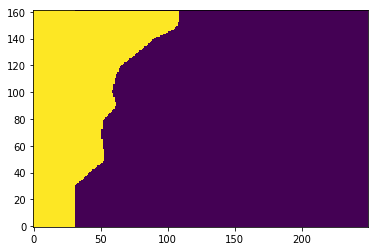

In [66]:
plt.imshow(fault_frame.T, origin='lower')
plt.show()

In [68]:
top_cloud = np.zeros(size_raster + (dz,))
base_cloud = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_cloud[x,y,:] = norm.pdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_cloud[x,y,:] = norm.pdf(zz,base_mean.values[x,y],base_std.values[x,y])


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [69]:
top_unit = np.zeros(size_raster + (dz,))
base_unit = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_unit[x,y,:] = 1 - norm.cdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_unit[x,y,:] = norm.cdf(zz,base_mean.values[x,y],base_std.values[x,y])
        
mid_unit = 1 - top_unit - base_unit

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
plt.imshow(top_cloud[50,:,:].T,origin='lower')
plt.show()

plt.imshow(base_cloud[50,:,:].T,origin='lower')
plt.show()

plt.imshow(0.5*(base_cloud[50,:,:]**3+top_cloud[50,:,:]**3).T,origin='lower')
plt.show()

In [62]:
r_horizons = np.zeros(size_raster + (dz,) + (len(rr),), dtype=np.uint8)

r_horizon[:] = np.nan

finish = 10

for r in rr[:finish]:
    for x in range(0,len(xx)): 
        for y in range(0,len(yy)):
            for z in range(0+1,len(zz)-1):
                if zz[z-1] <= base_cube[x,y,r] <= zz[z+1]:
                    r_horizons[x,y,z,r] = 1
                if zz[z-1] <= top_cube[x,y,r] <= zz[z+1]:
                    r_horizons[x,y,z,r] = 1
    print('%s '%r, end='')

np.save('realisation_1_10.npy', r_horizons)  

0 1 2 3 4 5 6 7 8 9 

(250, 162, 100, 200)


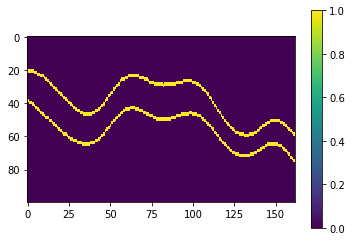

In [61]:
print(np.shape(r_horizons))
show_it(r_horizons[150,:,:,5])

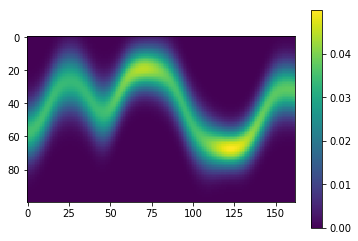

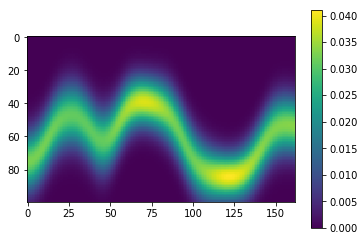

In [70]:
show_it(top_cloud[50,:,:])
show_it(base_cloud[50,:,:])

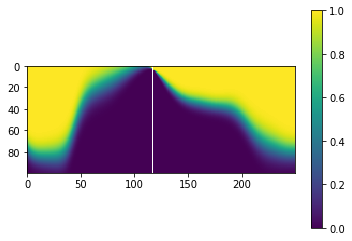

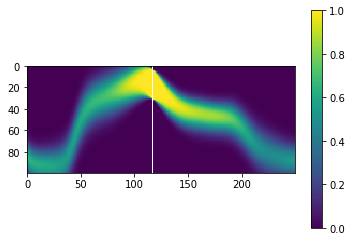

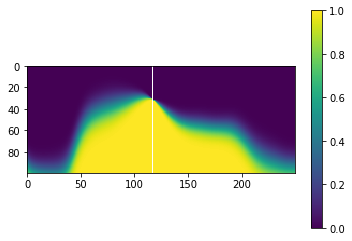

In [72]:
#170, 93

show_it(top_unit[:,93,:])
show_it(mid_unit[:,93,:])
show_it(base_unit[:,93,:])

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


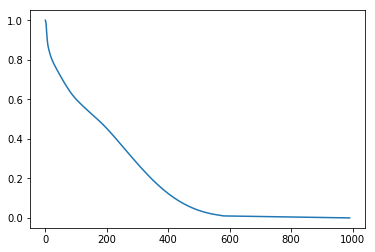

In [73]:
P_gates = np.linspace(0, 1, 100)
geo_volumes = []

for P_gate in P_gates:
    unit_poly = np.where(mid_unit>P_gate, mid_unit, 0).astype('bool')
    geo_volumes.append(unit_poly.sum()*25*25*4.04/10e6)

plt.plot(geo_volumes, P_gates)
plt.show()

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


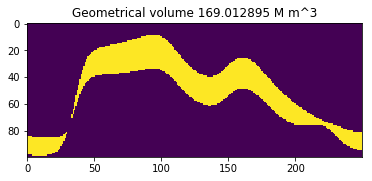

In [76]:
P_gate = 0.5

unit_poly = np.where(mid_unit>P_gate, mid_unit, 0).astype('bool')
geo_volume = unit_poly.sum()*25*25*4.04/10e6

plt.imshow(unit_poly[:,72].T, origin="upper")
plt.title('Geometrical volume %s M m^3' %geo_volume)
plt.show()